In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset
file_path = "covid_19_india.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# Display dataset structure and first few rows
print("\nDataset Overview:\n", df.info())
print("\nFirst 5 Rows:\n", df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB

Dataset Overview:
 None

First 5 Rows:
    Sno        Date     Time State/UnionTerritory ConfirmedIndianNational  \
0    1  2020-01-30  6:00 PM               Kerala                       1   
1    2  2020-01-31  6:00 PM               Kerala       

In [2]:
# Creating a Datetime column
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')
df.drop(['Date', 'Time'], axis=1, inplace=True)  # Dropping original columns


C:\Users\MSI\AppData\Local\Temp\ipykernel_33484\4096003231.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors='coerce')


In [3]:
# Standardizing State/UnionTerritory column
df['State/UnionTerritory'] = df['State/UnionTerritory'].str.strip().str.title()

In [4]:
# Converting relevant columns to numeric
numeric_cols = ['ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured', 'Deaths', 'Confirmed']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')


In [5]:
# Removing duplicates
print(f"Duplicates: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)

# Checking and correcting inconsistencies in Confirmed cases
df['Calc_Confirmed'] = df['ConfirmedIndianNational'] + df['ConfirmedForeignNational']
df.loc[df['Confirmed'].isna() | (df['Confirmed'] != df['Calc_Confirmed']), 'Confirmed'] = df['Calc_Confirmed']
df.drop('Calc_Confirmed', axis=1, inplace=True)

# Fixing negative values
df[numeric_cols] = df[numeric_cols].clip(lower=0)

# Handling missing values
df[numeric_cols] = df[numeric_cols].fillna(0)
df.dropna(subset=['Datetime', 'State/UnionTerritory'], inplace=True)

Duplicates: 0


In [6]:
# Summary statistics
print("\nSummary Statistics:\n", df[numeric_cols].describe())


Summary Statistics:
        ConfirmedIndianNational  ConfirmedForeignNational         Cured  \
count             18110.000000              18110.000000  1.811000e+04   
mean                  0.300166                  0.036830  2.786375e+05   
std                   3.874888                  0.606645  6.148909e+05   
min                   0.000000                  0.000000  0.000000e+00   
25%                   0.000000                  0.000000  3.360250e+03   
50%                   0.000000                  0.000000  3.336400e+04   
75%                   0.000000                  0.000000  2.788698e+05   
max                 177.000000                 14.000000  6.159676e+06   

              Deaths     Confirmed  
count   18110.000000  18110.000000  
mean     4052.402264      0.336996  
std     10919.076411      4.122471  
min         0.000000      0.000000  
25%        32.000000      0.000000  
50%       588.000000      0.000000  
75%      3643.750000      0.000000  
max    134201.0

In [7]:
# Most frequent states
print("\nTop 10 States/UTs by Frequency:\n", df['State/UnionTerritory'].value_counts().head(10))



Top 10 States/UTs by Frequency:
 State/UnionTerritory
Kerala               560
Delhi                528
Rajasthan            527
Uttar Pradesh        526
Haryana              526
Ladakh               523
Tamil Nadu           523
Punjab               521
Jammu And Kashmir    521
Maharashtra          520
Name: count, dtype: int64


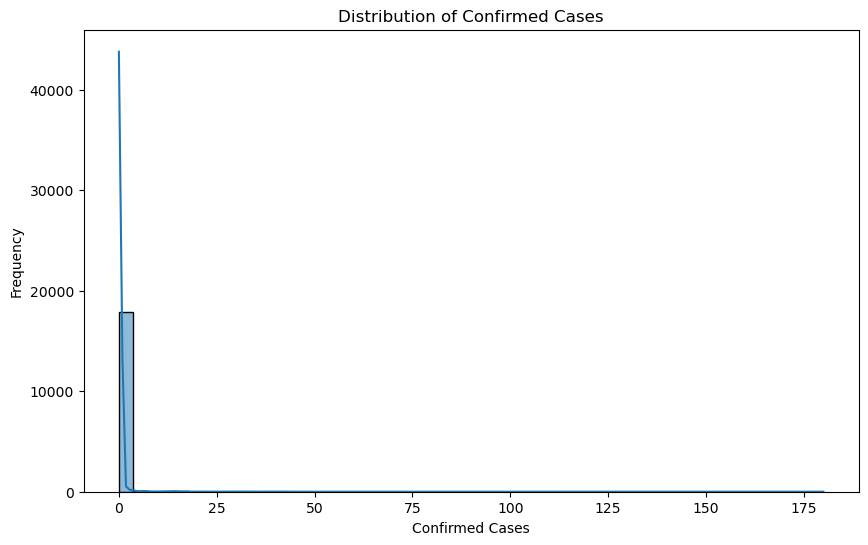

In [8]:
# Distribution plot for Confirmed cases
plt.figure(figsize=(10, 6))
sns.histplot(df['Confirmed'], bins=50, kde=True)
plt.title('Distribution of Confirmed Cases')
plt.xlabel('Confirmed Cases')
plt.ylabel('Frequency')
plt.savefig('confirmed_distribution.png')
plt.show()

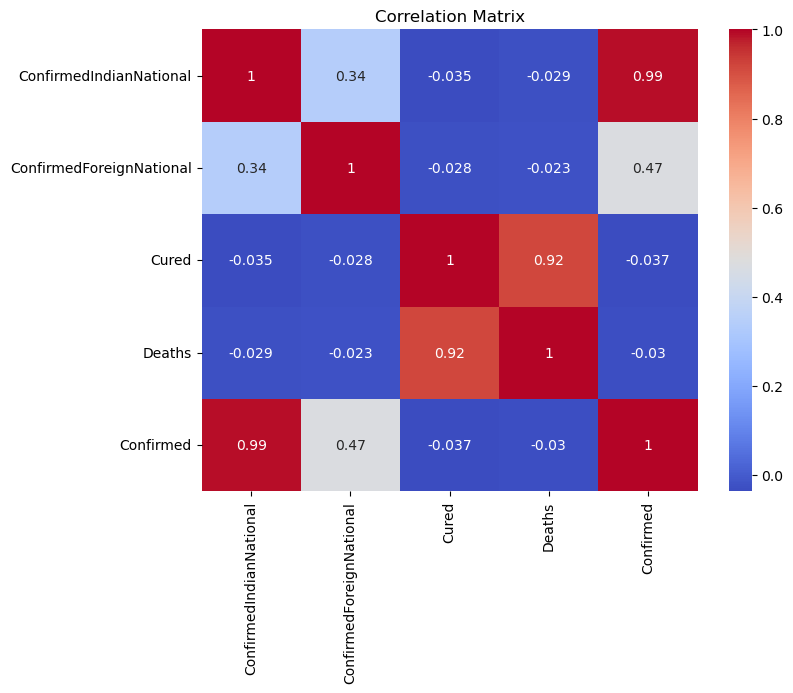

In [9]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_matrix.png')
plt.show()


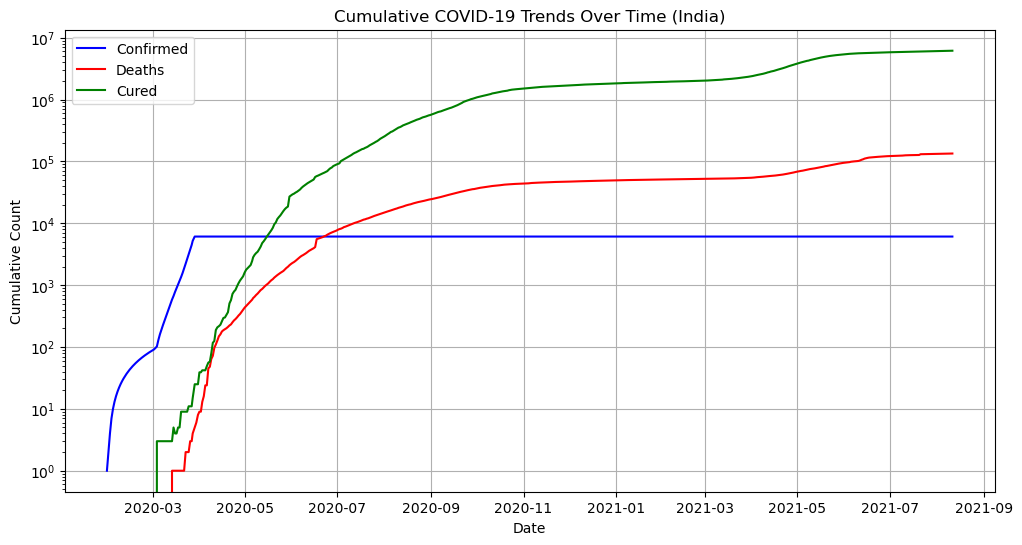

In [15]:
# Aggregate daily new cases (Confirmed) by summing across states
df_time = df.groupby('Datetime').agg({
    'Confirmed': 'sum',  # Sum daily new cases
    'Deaths': 'max',     # Take max of cumulative deaths
    'Cured': 'max'       # Take max of cumulative cured
}).reset_index()

# Calculate cumulative Confirmed
df_time['Cumulative_Confirmed'] = df_time['Confirmed'].cumsum()

# Deaths and Cured are already cumulative, so just rename
df_time['Cumulative_Deaths'] = df_time['Deaths']
df_time['Cumulative_Cured'] = df_time['Cured']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_time['Datetime'], df_time['Cumulative_Confirmed'], label='Confirmed', color='blue')
plt.plot(df_time['Datetime'], df_time['Cumulative_Deaths'], label='Deaths', color='red')
plt.plot(df_time['Datetime'], df_time['Cumulative_Cured'], label='Cured', color='green')
plt.title('Cumulative COVID-19 Trends Over Time (India)')
plt.xlabel('Date')
plt.ylabel('Cumulative Count')
plt.legend()
plt.grid(True)
plt.yscale('log')  # Log scale to see all lines clearly
plt.savefig('cumulative_trends_over_time_corrected.png')
plt.show()

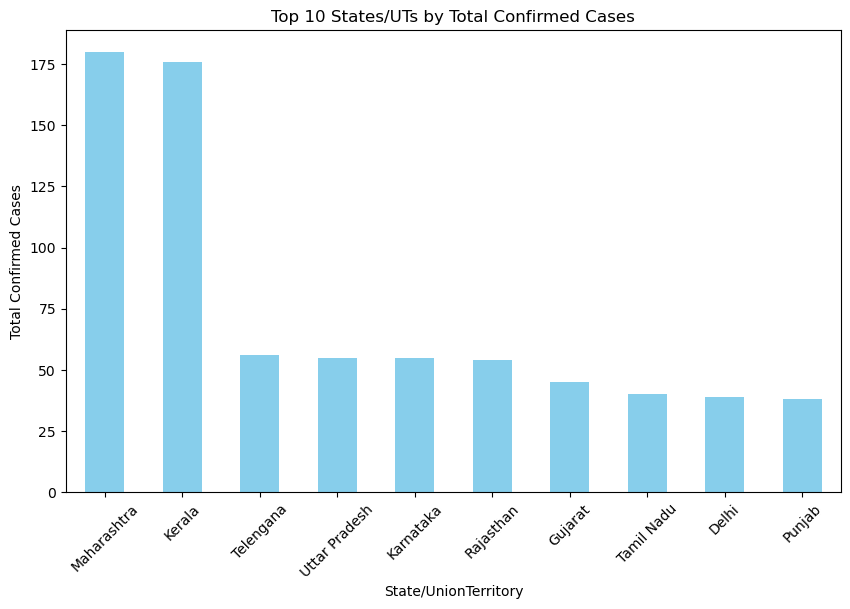

In [16]:
# Top 10 states by total confirmed cases
top_states = df.groupby('State/UnionTerritory')['Confirmed'].max().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
top_states.plot(kind='bar', color='skyblue')
plt.title('Top 10 States/UTs by Total Confirmed Cases')
plt.xlabel('State/UnionTerritory')
plt.ylabel('Total Confirmed Cases')
plt.xticks(rotation=45)
plt.savefig('top_states_confirmed.png')
plt.show()

In [17]:
# Save the cleaned dataset for Power BI
output_file = "cleaned_covid_data.csv"
df.to_csv(output_file, index=False)
print(f"Cleaned dataset saved as {output_file}")


Cleaned dataset saved as cleaned_covid_data.csv
